In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

import torchmetrics

import cv2

import config
import dataset
import models
import loss
import metrics
import train_epoch
import val_epoch
import utils

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = config.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            '\tMore checkpoints.\n' +
            f'\t{config.EPOCHS} epochs.\n' +
            '\tDataset images divided by 256.\n' +
            '\tAffine True for all BatchNorm Modules: fixed, as I forgot one module in previous experiment.\n')

# View Dataset

### Transform

In [4]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [5]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset.DFireDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    img_dir=config.val_imgs, 
    label_dir=config.val_labels, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

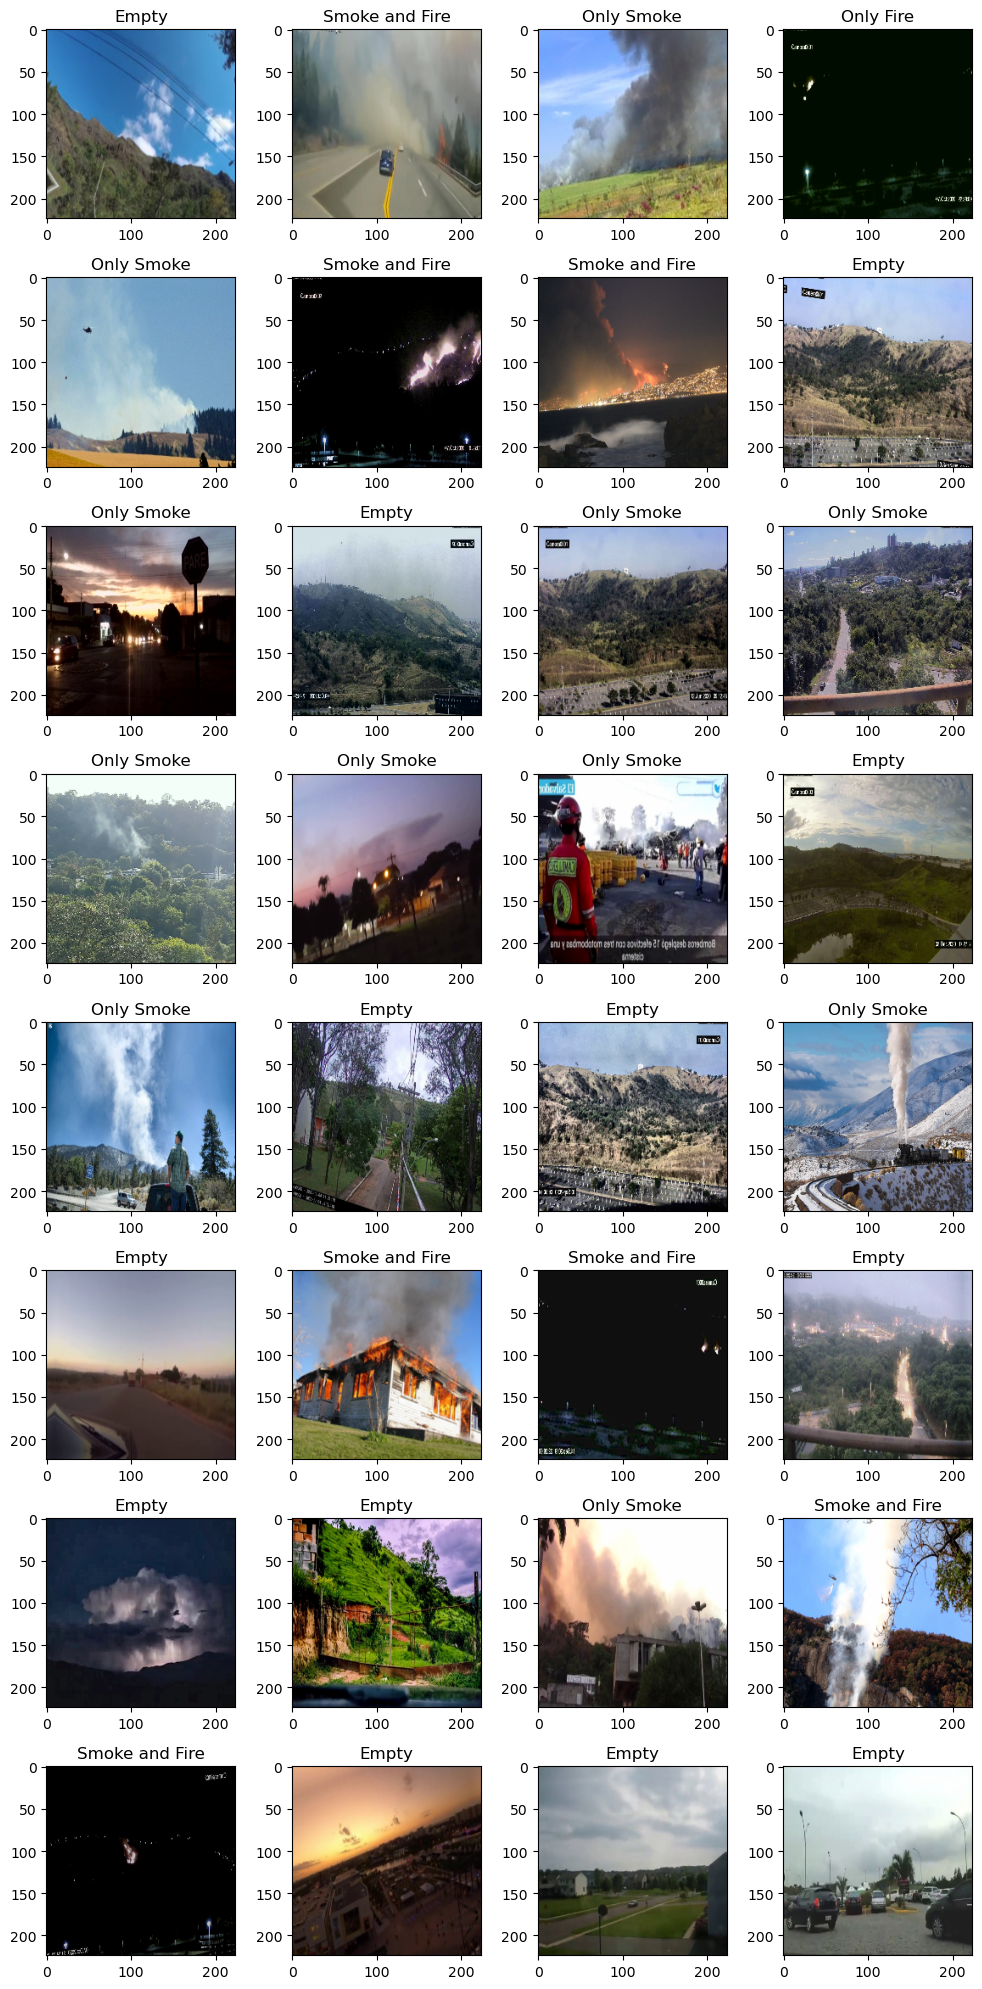

In [6]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [7]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.TRAIN_IMG_DIR,
    label_dir = config.TRAIN_LABEL_DIR,
    num_classes=config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'\tTrain dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(config.IMG_H, config.IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("TEST DFire dataset")
val_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.VAL_IMG_DIR,
    label_dir = config.VAL_LABEL_DIR,
    num_classes = config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'\tTest dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=config.BATCH_SIZE,
                          num_workers=config.NUM_WORKERS,
                          pin_memory=config.PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config.BATCH_SIZE,
                        num_workers=config.NUM_WORKERS,
                        pin_memory=config.PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [8]:
if config.MODEL == "BED":
    print("Using BED Classifier")
    logger.info("\nUsing BED Classifier")
    fp32_model = models.BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)   
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

optimizer = optim.Adam(fp32_model.parameters(), 
                       lr=config.LEARNING_RATE, 
                       weight_decay=config.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config.FACTOR, 
                                                 patience=config.PATIENCE, 
                                                 threshold=config.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config.MIN_LR)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in fp32_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(fp32_model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier

Trainable parameters = 93266
Total parameters = 93266



### Check Model Shape

In [9]:
in_rand_np = np.random.rand(4, 3, config.IMG_H, config.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config.DEVICE)
out_test = fp32_model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{fp32_model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{fp32_model}')

Model shape is tensor([[-0.0857,  0.1628],
        [-0.0685,  0.1097],
        [-0.2201,  0.1834],
        [-0.2427,  0.0667]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout2d(p=0.3, inplace=False)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (dropout2): Dropout2d(p=0.3, inplace=False)
    (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv31): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn31)

# Torchinfo: model summary

### FP32 Model

In [10]:
print(summary(fp32_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))
logger.info(summary(fp32_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
BED_CLASSIFIER                           [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Conv2d: 2-1                       [64, 32, 224, 224]        864
│    └─BatchNorm2d: 2-2                  [64, 32, 224, 224]        64
│    └─ReLU: 2-3                         [64, 32, 224, 224]        --
│    └─Dropout2d: 2-4                    [64, 32, 224, 224]        --
│    └─MaxPool2d: 2-5                    [64, 32, 112, 112]        --
│    └─Conv2d: 2-6                       [64, 16, 112, 112]        4,608
│    └─BatchNorm2d: 2-7                  [64, 16, 112, 112]        32
│    └─ReLU: 2-8                         [64, 16, 112, 112]        --
│    └─Dropout2d: 2-9                    [64, 16, 112, 112]        --
│    └─MaxPool2d: 2-10                   [64, 16, 56, 56]          --
│    └─Conv2d: 2-11                      [64, 16, 56, 56]          256
│    └─Bat

# Loss Function

In [11]:
if config.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'\nLoss Function: BCE')
    print(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config.DEVICE, smoke_precision_weight=config.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE
Smoke Precision Weight: 0.8


# Print and Log Config Values

In [12]:
''' ============================
    Print Config Values
============================ '''
print(f'\nDevice: {config.DEVICE}')
print(f'Learning Rate: {config.LEARNING_RATE}')
print(f'Weight Decay: {config.WEIGHT_DECAY}')
print(f'Batch Size: {config.BATCH_SIZE}')
print(f'IMG DIMS: ({config.IMG_H}, {config.IMG_W})')

logger.info(f'\nDevice: {config.DEVICE}')
logger.info(f'Learning Rate: {config.LEARNING_RATE}')
logger.info(f'Optimizer Weight Decay: {config.WEIGHT_DECAY}')
logger.info(f'Scheduler factor: {config.FACTOR}')
logger.info(f'Scheduler patience: {config.PATIENCE}')
logger.info(f'Scheduler threshold: {config.THRES}')
logger.info(f'Scheduler min learning rate: {config.MIN_LR}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')


Device: cuda
Learning Rate: 0.001
Weight Decay: 0.001
Batch Size: 64
IMG DIMS: (224, 224)


# Loss and Metrics Loggers and Plotters

In [13]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()
lr_logger = utils.LogLR(log_path=config.PLOTS_FOLDER)

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Metric')

# Main Function

In [14]:
def train_loop(model, start_epoch=0):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])

    #start_epoch = 0
    epochs_plot = []
        
    for epoch in range(start_epoch, config.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        current_lr = train_epoch.get_lr(optimizer=optimizer)
        logger.info(f'Learning Rate = {current_lr:.6f}\n')
        lr_logger.log_lr(current_lr)
                
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        lr_logger.plot_lr(epochs_plot)
        
        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__5epoch.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"Saving model with new best validation loss: {best_valid_loss:.3f}")
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + 'best_loss'  + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"Saving model with new best smoke precision: {best_smoke_precision:.3f}")
            save_precision_name = f'best_smoke__precision={np.round(best_smoke_precision, decimals=4)}__epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_precision_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if precision > 0.9 and recall > 0.9
        if ( val_metrics['Precision'][0] > 0.9 ) and ( val_metrics['Recall'][0] > 0.9 ) :
            print("\nSaving model with precision > 0.9 and recall > 0.9")
            logger.info("Saving model with precision > 0.9 and recall > 0.9")
            save_pre_name = f'smoke__precision={np.round(val_metrics["Precision"][0], decimals=4)}__' 
            save_rec_name = f'recall={np.round(val_metrics["Recall"][0], decimals=4)}__'
            save_pre_rec_name = save_pre_name + save_rec_name + f'epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_pre_rec_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), config.WEIGHTS_FOLDER + 'last_' + config.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [15]:
if __name__ == "__main__":
       
    trained_model = train_loop(model=fp32_model)


***Start Training: 16:33:54


=== EPOCH 0/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
68.679      |38.956      |29.722      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
63.784      |38.416      |25.369      
SMOKE -> Precision: 0.738 - Recall: 0.087 - Accuracy: 0.546 - F1: 0.156
FIRE -> Precision: 0.765 - Recall: 0.281 - Accuracy: 0.792 - F1: 0.411

Saving model with new best validation loss: 63.784

=== EPOCH 1/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
63.734      |37.940      |25.794      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
59.993      |37.127      |22.866      
SMOKE -> Precision: 0.681 - Recall: 0.410 - Accuracy: 0.624 - F1: 0.512
FIRE -> Precision: 0.682 - Recall: 0.724 - Accuracy: 0.841 - F1: 0.702

Saving model with new best validation loss: 59.993

=== EPOCH 2/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
59.779      |36.861      |22.917      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.788      |35.666      |19.122      
SMOKE -> Precision: 0.737 - Recall: 0.432 - Accuracy: 0.653 - F1: 0.545
FIRE -> Precision: 0.727 - Recall: 0.769 - Accuracy: 0.866 - F1: 0.748

Saving model with new best validation loss: 54.788

=== EPOCH 3/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.798      |36.101      |21.697      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.767      |34.750      |19.017      
SMOKE -> Precision: 0.741 - Recall: 0.411 - Accuracy: 0.647 - F1: 0.528
FIRE -> Precision: 0.854 - Recall: 0.656 - Accuracy: 0.882 - F1: 0.742

Saving model with new best validation loss: 53.767

=== EPOCH 4/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.088      |35.577      |20.511      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.892      |34.532      |17.360      
SMOKE -> Precision: 0.798 - Recall: 0.349 - Accuracy: 0.644 - F1: 0.485
FIRE -> Precision: 0.839 - Recall: 0.721 - Accuracy: 0.892 - F1: 0.776

Saving model with new best validation loss: 51.892

=== EPOCH 5/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.770      |35.054      |19.716      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.756      |33.204      |15.551      
SMOKE -> Precision: 0.742 - Recall: 0.556 - Accuracy: 0.693 - F1: 0.636
FIRE -> Precision: 0.797 - Recall: 0.846 - Accuracy: 0.904 - F1: 0.821

Saving model with new best validation loss: 48.756

=== EPOCH 6/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:21<00:00, 12.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.345      |34.426      |18.919      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.173      |32.661      |15.512      
SMOKE -> Precision: 0.795 - Recall: 0.458 - Accuracy: 0.682 - F1: 0.581
FIRE -> Precision: 0.902 - Recall: 0.738 - Accuracy: 0.911 - F1: 0.812

Saving model with new best validation loss: 48.173

=== EPOCH 7/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.811      |33.923      |17.888      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.101      |31.477      |13.624      
SMOKE -> Precision: 0.790 - Recall: 0.517 - Accuracy: 0.701 - F1: 0.625
FIRE -> Precision: 0.881 - Recall: 0.800 - Accuracy: 0.920 - F1: 0.839

Saving model with new best validation loss: 45.101

=== EPOCH 8/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.546      |33.207      |17.339      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.616      |31.866      |13.750      
SMOKE -> Precision: 0.776 - Recall: 0.508 - Accuracy: 0.693 - F1: 0.614
FIRE -> Precision: 0.839 - Recall: 0.843 - Accuracy: 0.918 - F1: 0.841

=== EPOCH 9/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.624      |32.809      |16.815      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.265      |30.865      |13.401      
SMOKE -> Precision: 0.839 - Recall: 0.503 - Accuracy: 0.715 - F1: 0.629
FIRE -> Precision: 0.925 - Recall: 0.792 - Accuracy: 0.930 - F1: 0.853

Saving model with new best validation loss: 44.265

=== EPOCH 10/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.861      |32.372      |16.489      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.652      |30.596      |13.056      
SMOKE -> Precision: 0.789 - Recall: 0.548 - Accuracy: 0.712 - F1: 0.647
FIRE -> Precision: 0.845 - Recall: 0.848 - Accuracy: 0.920 - F1: 0.847

Saving model with new best validation loss: 43.652

=== EPOCH 11/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.864      |32.122      |15.742      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.062      |30.023      |12.039      
SMOKE -> Precision: 0.815 - Recall: 0.538 - Accuracy: 0.719 - F1: 0.648
FIRE -> Precision: 0.856 - Recall: 0.874 - Accuracy: 0.929 - F1: 0.865

Saving model with new best validation loss: 42.062

=== EPOCH 12/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.783      |31.901      |15.882      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.472      |30.420      |12.052      
SMOKE -> Precision: 0.802 - Recall: 0.559 - Accuracy: 0.721 - F1: 0.659
FIRE -> Precision: 0.857 - Recall: 0.874 - Accuracy: 0.930 - F1: 0.865

=== EPOCH 13/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.666      |31.436      |15.231      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.975      |29.785      |12.190      
SMOKE -> Precision: 0.786 - Recall: 0.590 - Accuracy: 0.725 - F1: 0.674
FIRE -> Precision: 0.908 - Recall: 0.822 - Accuracy: 0.932 - F1: 0.863

Saving model with new best validation loss: 41.975

=== EPOCH 14/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.662      |30.846      |14.815      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.901      |28.800      |12.101      
SMOKE -> Precision: 0.824 - Recall: 0.561 - Accuracy: 0.731 - F1: 0.668
FIRE -> Precision: 0.909 - Recall: 0.830 - Accuracy: 0.934 - F1: 0.868

Saving model with new best validation loss: 40.901

=== EPOCH 15/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.234      |30.700      |14.535      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.379      |28.471      |10.908      
SMOKE -> Precision: 0.865 - Recall: 0.520 - Accuracy: 0.730 - F1: 0.650
FIRE -> Precision: 0.921 - Recall: 0.841 - Accuracy: 0.940 - F1: 0.879

Saving model with new best validation loss: 39.379

=== EPOCH 16/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.459      |30.015      |14.444      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.373      |27.575      |10.798      
SMOKE -> Precision: 0.865 - Recall: 0.558 - Accuracy: 0.745 - F1: 0.678
FIRE -> Precision: 0.907 - Recall: 0.866 - Accuracy: 0.942 - F1: 0.886

Saving model with new best validation loss: 38.373

=== EPOCH 17/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.434      |30.118      |14.316      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.422      |26.636      |11.786      
SMOKE -> Precision: 0.861 - Recall: 0.575 - Accuracy: 0.751 - F1: 0.689
FIRE -> Precision: 0.915 - Recall: 0.829 - Accuracy: 0.936 - F1: 0.870

=== EPOCH 18/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.654      |29.705      |13.949      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.574      |26.762      |10.811      
SMOKE -> Precision: 0.859 - Recall: 0.558 - Accuracy: 0.743 - F1: 0.676
FIRE -> Precision: 0.925 - Recall: 0.834 - Accuracy: 0.940 - F1: 0.877

Saving model with new best validation loss: 37.574

=== EPOCH 19/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.233      |29.413      |13.820      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.671      |26.189      |10.481      
SMOKE -> Precision: 0.800 - Recall: 0.716 - Accuracy: 0.777 - F1: 0.756
FIRE -> Precision: 0.919 - Recall: 0.863 - Accuracy: 0.945 - F1: 0.890

Saving model with new best validation loss: 36.671

=== EPOCH 20/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.257      |28.744      |13.513      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.362      |25.428      |10.934      
SMOKE -> Precision: 0.855 - Recall: 0.641 - Accuracy: 0.775 - F1: 0.733
FIRE -> Precision: 0.939 - Recall: 0.830 - Accuracy: 0.942 - F1: 0.881

Saving model with new best validation loss: 36.362

=== EPOCH 21/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.792      |28.412      |13.381      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.631      |27.709      |13.923      
SMOKE -> Precision: 0.886 - Recall: 0.493 - Accuracy: 0.726 - F1: 0.633
FIRE -> Precision: 0.958 - Recall: 0.728 - Accuracy: 0.921 - F1: 0.827

=== EPOCH 22/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.846      |28.434      |13.411      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.095      |24.884      |10.211      
SMOKE -> Precision: 0.822 - Recall: 0.748 - Accuracy: 0.801 - F1: 0.784
FIRE -> Precision: 0.933 - Recall: 0.846 - Accuracy: 0.944 - F1: 0.888

Saving model with new best validation loss: 35.095

=== EPOCH 23/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.610      |28.360      |13.251      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.988      |24.543      |10.445      
SMOKE -> Precision: 0.834 - Recall: 0.703 - Accuracy: 0.790 - F1: 0.763
FIRE -> Precision: 0.933 - Recall: 0.841 - Accuracy: 0.943 - F1: 0.885

Saving model with new best validation loss: 34.988

=== EPOCH 24/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.427      |27.726      |12.701      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.399      |25.192      |10.207      
SMOKE -> Precision: 0.875 - Recall: 0.589 - Accuracy: 0.762 - F1: 0.704
FIRE -> Precision: 0.913 - Recall: 0.874 - Accuracy: 0.946 - F1: 0.893

=== EPOCH 25/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.372      |27.774      |12.598      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.797      |26.089      |10.708      
SMOKE -> Precision: 0.895 - Recall: 0.541 - Accuracy: 0.749 - F1: 0.674
FIRE -> Precision: 0.959 - Recall: 0.818 - Accuracy: 0.944 - F1: 0.883

=== EPOCH 26/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.944      |27.277      |12.667      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.535      |27.679      |12.856      
SMOKE -> Precision: 0.903 - Recall: 0.470 - Accuracy: 0.721 - F1: 0.618
FIRE -> Precision: 0.975 - Recall: 0.759 - Accuracy: 0.933 - F1: 0.854

=== EPOCH 27/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.103      |26.998      |12.104      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.841      |25.308      |9.533       
SMOKE -> Precision: 0.886 - Recall: 0.572 - Accuracy: 0.759 - F1: 0.695
FIRE -> Precision: 0.948 - Recall: 0.859 - Accuracy: 0.951 - F1: 0.901

Saving model with new best validation loss: 34.841

=== EPOCH 28/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.321      |26.358      |11.963      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.549      |25.295      |10.253      
SMOKE -> Precision: 0.877 - Recall: 0.572 - Accuracy: 0.756 - F1: 0.692
FIRE -> Precision: 0.943 - Recall: 0.855 - Accuracy: 0.949 - F1: 0.897

=== EPOCH 29/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.396      |26.381      |12.015      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.057      |22.727      |10.330      
SMOKE -> Precision: 0.831 - Recall: 0.793 - Accuracy: 0.823 - F1: 0.811
FIRE -> Precision: 0.945 - Recall: 0.848 - Accuracy: 0.948 - F1: 0.894

Saving model with new best validation loss: 33.057

=== EPOCH 30/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.706      |26.134      |11.572      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.432      |22.329      |9.103       
SMOKE -> Precision: 0.877 - Recall: 0.704 - Accuracy: 0.810 - F1: 0.781
FIRE -> Precision: 0.917 - Recall: 0.890 - Accuracy: 0.951 - F1: 0.904

Saving model with new best validation loss: 31.432

=== EPOCH 31/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.778      |26.164      |11.614      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.815      |22.384      |10.431      
SMOKE -> Precision: 0.872 - Recall: 0.705 - Accuracy: 0.808 - F1: 0.780
FIRE -> Precision: 0.958 - Recall: 0.818 - Accuracy: 0.944 - F1: 0.882

=== EPOCH 32/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.549      |25.798      |11.751      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.572      |21.796      |8.777       
SMOKE -> Precision: 0.877 - Recall: 0.738 - Accuracy: 0.824 - F1: 0.801
FIRE -> Precision: 0.931 - Recall: 0.883 - Accuracy: 0.953 - F1: 0.906

Saving model with new best validation loss: 30.572

=== EPOCH 33/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.801      |25.180      |11.621      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.991      |23.419      |9.572       
SMOKE -> Precision: 0.910 - Recall: 0.632 - Accuracy: 0.793 - F1: 0.746
FIRE -> Precision: 0.939 - Recall: 0.856 - Accuracy: 0.948 - F1: 0.895

=== EPOCH 34/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.479      |25.108      |11.371      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.831      |21.371      |8.461       
SMOKE -> Precision: 0.891 - Recall: 0.721 - Accuracy: 0.823 - F1: 0.797
FIRE -> Precision: 0.921 - Recall: 0.901 - Accuracy: 0.954 - F1: 0.911

Saving model with new best validation loss: 29.831

=== EPOCH 35/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.324      |24.852      |11.473      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.764      |23.137      |9.627       
SMOKE -> Precision: 0.884 - Recall: 0.662 - Accuracy: 0.795 - F1: 0.757
FIRE -> Precision: 0.949 - Recall: 0.853 - Accuracy: 0.950 - F1: 0.898

=== EPOCH 36/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.848      |24.777      |11.071      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.562      |20.553      |9.010       
SMOKE -> Precision: 0.864 - Recall: 0.813 - Accuracy: 0.848 - F1: 0.838
FIRE -> Precision: 0.949 - Recall: 0.863 - Accuracy: 0.953 - F1: 0.904

Saving model with new best validation loss: 29.562

=== EPOCH 37/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.038      |24.638      |11.400      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.985      |20.893      |9.092       
SMOKE -> Precision: 0.835 - Recall: 0.842 - Accuracy: 0.844 - F1: 0.839
FIRE -> Precision: 0.889 - Recall: 0.915 - Accuracy: 0.948 - F1: 0.902

=== EPOCH 38/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.348      |24.419      |10.929      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.244      |20.354      |8.890       
SMOKE -> Precision: 0.848 - Recall: 0.831 - Accuracy: 0.847 - F1: 0.839
FIRE -> Precision: 0.950 - Recall: 0.883 - Accuracy: 0.958 - F1: 0.915

Saving model with new best validation loss: 29.244

=== EPOCH 39/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.157      |24.042      |11.115      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.149      |20.724      |10.425      
SMOKE -> Precision: 0.888 - Recall: 0.757 - Accuracy: 0.837 - F1: 0.817
FIRE -> Precision: 0.959 - Recall: 0.805 - Accuracy: 0.941 - F1: 0.875

=== EPOCH 40/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.934      |24.164      |10.770      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.394      |21.228      |9.166       
SMOKE -> Precision: 0.905 - Recall: 0.708 - Accuracy: 0.824 - F1: 0.794
FIRE -> Precision: 0.942 - Recall: 0.871 - Accuracy: 0.953 - F1: 0.905

=== EPOCH 41/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.142      |24.248      |10.895      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.824      |23.215      |8.609       
SMOKE -> Precision: 0.764 - Recall: 0.918 - Accuracy: 0.824 - F1: 0.834
FIRE -> Precision: 0.924 - Recall: 0.892 - Accuracy: 0.953 - F1: 0.907

=== EPOCH 42/139 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.904      |23.433      |10.471      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.581      |19.994      |8.587       
SMOKE -> Precision: 0.900 - Recall: 0.743 - Accuracy: 0.836 - F1: 0.814
FIRE -> Precision: 0.952 - Recall: 0.875 - Accuracy: 0.956 - F1: 0.912

Saving model with new best validation loss: 28.581

=== EPOCH 43/139 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.354      |23.019      |10.334      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.928      |19.169      |9.759       
SMOKE -> Precision: 0.877 - Recall: 0.802 - Accuracy: 0.851 - F1: 0.838
FIRE -> Precision: 0.961 - Recall: 0.841 - Accuracy: 0.950 - F1: 0.897

=== EPOCH 44/139 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.204      |22.994      |10.210      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.702      |20.542      |8.160       
SMOKE -> Precision: 0.905 - Recall: 0.736 - Accuracy: 0.836 - F1: 0.812
FIRE -> Precision: 0.945 - Recall: 0.895 - Accuracy: 0.959 - F1: 0.919

=== EPOCH 45/139 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.426      |22.855      |10.571      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.362      |20.201      |8.162       
SMOKE -> Precision: 0.896 - Recall: 0.748 - Accuracy: 0.837 - F1: 0.815
FIRE -> Precision: 0.950 - Recall: 0.882 - Accuracy: 0.958 - F1: 0.915

Saving model with new best validation loss: 28.362

=== EPOCH 46/139 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.597      |22.610      |9.987       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.469      |18.205      |8.263       
SMOKE -> Precision: 0.872 - Recall: 0.860 - Accuracy: 0.872 - F1: 0.866
FIRE -> Precision: 0.958 - Recall: 0.877 - Accuracy: 0.958 - F1: 0.916

Saving model with new best validation loss: 26.469

=== EPOCH 47/139 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.789      |22.454      |10.335      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.767      |18.265      |8.502       
SMOKE -> Precision: 0.888 - Recall: 0.810 - Accuracy: 0.859 - F1: 0.847
FIRE -> Precision: 0.956 - Recall: 0.871 - Accuracy: 0.956 - F1: 0.911

=== EPOCH 48/139 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.246      |22.204      |10.042      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.636      |19.614      |8.023       
SMOKE -> Precision: 0.914 - Recall: 0.757 - Accuracy: 0.849 - F1: 0.828
FIRE -> Precision: 0.948 - Recall: 0.899 - Accuracy: 0.961 - F1: 0.923

=== EPOCH 49/139 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.610      |22.432      |10.179      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.107      |18.850      |8.257       
SMOKE -> Precision: 0.835 - Recall: 0.908 - Accuracy: 0.870 - F1: 0.870
FIRE -> Precision: 0.916 - Recall: 0.908 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 50/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.833      |21.940      |9.893       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.685      |17.709      |7.977       
SMOKE -> Precision: 0.871 - Recall: 0.866 - Accuracy: 0.874 - F1: 0.869
FIRE -> Precision: 0.932 - Recall: 0.908 - Accuracy: 0.959 - F1: 0.920

Saving model with new best validation loss: 25.685

=== EPOCH 51/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.505      |21.690      |9.814       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.178      |18.937      |9.241       
SMOKE -> Precision: 0.902 - Recall: 0.757 - Accuracy: 0.843 - F1: 0.823
FIRE -> Precision: 0.968 - Recall: 0.845 - Accuracy: 0.953 - F1: 0.902

=== EPOCH 52/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.246      |21.546      |9.701       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.215      |17.474      |7.741       
SMOKE -> Precision: 0.892 - Recall: 0.827 - Accuracy: 0.869 - F1: 0.858
FIRE -> Precision: 0.954 - Recall: 0.893 - Accuracy: 0.961 - F1: 0.922

Saving model with new best validation loss: 25.215

=== EPOCH 53/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.210      |21.803      |9.407       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.240      |18.602      |8.639       
SMOKE -> Precision: 0.901 - Recall: 0.771 - Accuracy: 0.849 - F1: 0.831
FIRE -> Precision: 0.957 - Recall: 0.877 - Accuracy: 0.958 - F1: 0.915

=== EPOCH 54/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.782      |21.228      |9.554       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.082      |17.675      |8.407       
SMOKE -> Precision: 0.904 - Recall: 0.808 - Accuracy: 0.866 - F1: 0.853
FIRE -> Precision: 0.954 - Recall: 0.866 - Accuracy: 0.955 - F1: 0.908

=== EPOCH 55/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.615      |21.027      |9.588       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.784      |16.964      |7.820       
SMOKE -> Precision: 0.888 - Recall: 0.860 - Accuracy: 0.881 - F1: 0.874
FIRE -> Precision: 0.955 - Recall: 0.889 - Accuracy: 0.961 - F1: 0.921

Saving model with new best validation loss: 24.784

=== EPOCH 56/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.460      |20.980      |9.480       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.395      |19.075      |8.319       
SMOKE -> Precision: 0.840 - Recall: 0.890 - Accuracy: 0.865 - F1: 0.864
FIRE -> Precision: 0.944 - Recall: 0.883 - Accuracy: 0.956 - F1: 0.912

=== EPOCH 57/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.318      |21.142      |9.176       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.708      |17.057      |7.651       
SMOKE -> Precision: 0.892 - Recall: 0.849 - Accuracy: 0.878 - F1: 0.870
FIRE -> Precision: 0.928 - Recall: 0.908 - Accuracy: 0.958 - F1: 0.918

Saving model with new best validation loss: 24.708

=== EPOCH 58/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.601      |21.035      |9.566       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.459      |16.705      |7.754       
SMOKE -> Precision: 0.882 - Recall: 0.858 - Accuracy: 0.876 - F1: 0.870
FIRE -> Precision: 0.929 - Recall: 0.913 - Accuracy: 0.959 - F1: 0.920

Saving model with new best validation loss: 24.459

=== EPOCH 59/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.093      |20.330      |9.763       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.277      |16.245      |8.032       
SMOKE -> Precision: 0.895 - Recall: 0.868 - Accuracy: 0.888 - F1: 0.881
FIRE -> Precision: 0.948 - Recall: 0.889 - Accuracy: 0.959 - F1: 0.918

Saving model with new best validation loss: 24.277

=== EPOCH 60/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.812      |20.706      |9.106       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.909      |17.047      |8.862       
SMOKE -> Precision: 0.875 - Recall: 0.855 - Accuracy: 0.872 - F1: 0.865
FIRE -> Precision: 0.955 - Recall: 0.872 - Accuracy: 0.956 - F1: 0.911

=== EPOCH 61/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.008      |20.615      |9.393       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.887      |16.777      |8.110       
SMOKE -> Precision: 0.891 - Recall: 0.843 - Accuracy: 0.875 - F1: 0.867
FIRE -> Precision: 0.953 - Recall: 0.886 - Accuracy: 0.959 - F1: 0.918

=== EPOCH 62/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.552      |20.277      |9.275       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.070      |17.148      |7.921       
SMOKE -> Precision: 0.900 - Recall: 0.819 - Accuracy: 0.869 - F1: 0.858
FIRE -> Precision: 0.958 - Recall: 0.886 - Accuracy: 0.961 - F1: 0.921

=== EPOCH 63/139 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.275      |19.984      |9.290       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.972      |17.895      |8.076       
SMOKE -> Precision: 0.867 - Recall: 0.854 - Accuracy: 0.866 - F1: 0.860
FIRE -> Precision: 0.948 - Recall: 0.886 - Accuracy: 0.958 - F1: 0.916

=== EPOCH 64/139 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.658      |19.921      |8.737       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.519      |16.587      |7.932       
SMOKE -> Precision: 0.880 - Recall: 0.881 - Accuracy: 0.885 - F1: 0.880
FIRE -> Precision: 0.960 - Recall: 0.881 - Accuracy: 0.960 - F1: 0.919

=== EPOCH 65/139 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.329      |19.529      |8.800       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.663      |16.040      |7.623       
SMOKE -> Precision: 0.895 - Recall: 0.864 - Accuracy: 0.885 - F1: 0.879
FIRE -> Precision: 0.953 - Recall: 0.890 - Accuracy: 0.960 - F1: 0.920

Saving model with new best validation loss: 23.663

=== EPOCH 66/139 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.357      |19.314      |9.043       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.969      |16.149      |7.820       
SMOKE -> Precision: 0.898 - Recall: 0.854 - Accuracy: 0.883 - F1: 0.875
FIRE -> Precision: 0.954 - Recall: 0.886 - Accuracy: 0.960 - F1: 0.919

=== EPOCH 67/139 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.680      |19.776      |8.905       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.920      |16.754      |8.166       
SMOKE -> Precision: 0.911 - Recall: 0.813 - Accuracy: 0.872 - F1: 0.859
FIRE -> Precision: 0.963 - Recall: 0.873 - Accuracy: 0.958 - F1: 0.916

=== EPOCH 68/139 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.245      |19.308      |8.937       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.568      |16.022      |8.546       
SMOKE -> Precision: 0.921 - Recall: 0.823 - Accuracy: 0.881 - F1: 0.869
FIRE -> Precision: 0.974 - Recall: 0.859 - Accuracy: 0.958 - F1: 0.913

=== EPOCH 69/139 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.149      |19.207      |8.942       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.779      |16.279      |7.500       
SMOKE -> Precision: 0.898 - Recall: 0.849 - Accuracy: 0.881 - F1: 0.873
FIRE -> Precision: 0.920 - Recall: 0.916 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 70/139 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.373      |18.906      |8.467       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.903      |16.375      |7.527       
SMOKE -> Precision: 0.903 - Recall: 0.847 - Accuracy: 0.882 - F1: 0.874
FIRE -> Precision: 0.947 - Recall: 0.902 - Accuracy: 0.962 - F1: 0.924

=== EPOCH 71/139 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.391      |18.754      |8.636       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.594      |15.036      |7.557       
SMOKE -> Precision: 0.885 - Recall: 0.904 - Accuracy: 0.897 - F1: 0.894
FIRE -> Precision: 0.945 - Recall: 0.901 - Accuracy: 0.961 - F1: 0.923

Saving model with new best validation loss: 22.594

=== EPOCH 72/139 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.501      |18.753      |8.748       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.138      |14.744      |7.394       
SMOKE -> Precision: 0.910 - Recall: 0.882 - Accuracy: 0.901 - F1: 0.896
FIRE -> Precision: 0.935 - Recall: 0.904 - Accuracy: 0.959 - F1: 0.919

Saving model with new best validation loss: 22.138

=== EPOCH 73/139 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.486      |18.887      |8.599       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.151      |16.285      |8.866       
SMOKE -> Precision: 0.918 - Recall: 0.827 - Accuracy: 0.882 - F1: 0.870
FIRE -> Precision: 0.972 - Recall: 0.852 - Accuracy: 0.955 - F1: 0.908

=== EPOCH 74/139 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.201      |18.740      |8.461       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.283      |14.883      |7.400       
SMOKE -> Precision: 0.909 - Recall: 0.878 - Accuracy: 0.899 - F1: 0.893
FIRE -> Precision: 0.959 - Recall: 0.886 - Accuracy: 0.961 - F1: 0.921

=== EPOCH 75/139 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.146      |18.529      |8.617       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.791      |15.356      |7.434       
SMOKE -> Precision: 0.907 - Recall: 0.861 - Accuracy: 0.890 - F1: 0.883
FIRE -> Precision: 0.940 - Recall: 0.905 - Accuracy: 0.960 - F1: 0.922

=== EPOCH 76/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.711      |18.148      |8.563       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.451      |15.893      |7.559       
SMOKE -> Precision: 0.898 - Recall: 0.867 - Accuracy: 0.889 - F1: 0.882
FIRE -> Precision: 0.944 - Recall: 0.895 - Accuracy: 0.959 - F1: 0.919

=== EPOCH 77/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.364      |18.209      |8.155       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.480      |15.352      |7.128       
SMOKE -> Precision: 0.880 - Recall: 0.910 - Accuracy: 0.897 - F1: 0.894
FIRE -> Precision: 0.941 - Recall: 0.914 - Accuracy: 0.963 - F1: 0.927

=== EPOCH 78/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.792      |18.344      |8.449       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.220      |15.675      |7.546       
SMOKE -> Precision: 0.884 - Recall: 0.886 - Accuracy: 0.889 - F1: 0.885
FIRE -> Precision: 0.941 - Recall: 0.909 - Accuracy: 0.962 - F1: 0.925

=== EPOCH 79/139 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.831      |17.682      |8.148       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.914      |14.667      |7.248       
SMOKE -> Precision: 0.900 - Recall: 0.891 - Accuracy: 0.900 - F1: 0.895
FIRE -> Precision: 0.943 - Recall: 0.908 - Accuracy: 0.962 - F1: 0.925

Saving model with new best validation loss: 21.914

=== EPOCH 80/139 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.842      |17.717      |8.126       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.312      |14.988      |7.324       
SMOKE -> Precision: 0.915 - Recall: 0.865 - Accuracy: 0.897 - F1: 0.890
FIRE -> Precision: 0.950 - Recall: 0.901 - Accuracy: 0.962 - F1: 0.925

=== EPOCH 81/139 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.618      |17.652      |7.966       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.658      |15.148      |7.510       
SMOKE -> Precision: 0.884 - Recall: 0.897 - Accuracy: 0.894 - F1: 0.891
FIRE -> Precision: 0.942 - Recall: 0.907 - Accuracy: 0.962 - F1: 0.924

=== EPOCH 82/139 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.153      |17.419      |7.734       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.960      |14.676      |7.284       
SMOKE -> Precision: 0.899 - Recall: 0.890 - Accuracy: 0.899 - F1: 0.895
FIRE -> Precision: 0.935 - Recall: 0.908 - Accuracy: 0.960 - F1: 0.921

=== EPOCH 83/139 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.372      |17.493      |7.879       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.444      |14.442      |7.002       
SMOKE -> Precision: 0.900 - Recall: 0.888 - Accuracy: 0.899 - F1: 0.894
FIRE -> Precision: 0.947 - Recall: 0.905 - Accuracy: 0.962 - F1: 0.926

Saving model with new best validation loss: 21.444

=== EPOCH 84/139 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.394      |17.355      |8.039       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.238      |14.970      |7.268       
SMOKE -> Precision: 0.912 - Recall: 0.867 - Accuracy: 0.896 - F1: 0.889
FIRE -> Precision: 0.959 - Recall: 0.893 - Accuracy: 0.962 - F1: 0.925

=== EPOCH 85/139 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.326      |17.367      |7.958       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.464      |14.455      |7.010       
SMOKE -> Precision: 0.893 - Recall: 0.912 - Accuracy: 0.905 - F1: 0.902
FIRE -> Precision: 0.943 - Recall: 0.912 - Accuracy: 0.963 - F1: 0.927

Saving model with new best smoke precision: 0.893

=== EPOCH 86/139 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.787      |16.950      |7.837       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.814      |15.515      |7.299       
SMOKE -> Precision: 0.920 - Recall: 0.842 - Accuracy: 0.889 - F1: 0.879
FIRE -> Precision: 0.957 - Recall: 0.897 - Accuracy: 0.963 - F1: 0.926

=== EPOCH 87/139 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.359      |16.739      |7.620       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.190      |14.937      |7.254       
SMOKE -> Precision: 0.906 - Recall: 0.863 - Accuracy: 0.891 - F1: 0.884
FIRE -> Precision: 0.956 - Recall: 0.895 - Accuracy: 0.962 - F1: 0.925

=== EPOCH 88/139 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.966      |17.063      |7.903       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.672      |14.372      |7.300       
SMOKE -> Precision: 0.910 - Recall: 0.881 - Accuracy: 0.901 - F1: 0.895
FIRE -> Precision: 0.955 - Recall: 0.904 - Accuracy: 0.964 - F1: 0.929

=== EPOCH 89/139 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.721      |16.834      |7.888       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.721      |14.257      |7.464       
SMOKE -> Precision: 0.907 - Recall: 0.900 - Accuracy: 0.907 - F1: 0.903
FIRE -> Precision: 0.960 - Recall: 0.893 - Accuracy: 0.963 - F1: 0.925

Saving model with new best smoke precision: 0.907

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 90/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.703      |16.867      |7.836       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.939      |14.029      |6.910       
SMOKE -> Precision: 0.913 - Recall: 0.882 - Accuracy: 0.903 - F1: 0.897
FIRE -> Precision: 0.951 - Recall: 0.914 - Accuracy: 0.966 - F1: 0.932

Saving model with new best validation loss: 20.939

=== EPOCH 91/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.396      |16.668      |7.729       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.045      |13.974      |7.070       
SMOKE -> Precision: 0.904 - Recall: 0.902 - Accuracy: 0.907 - F1: 0.903
FIRE -> Precision: 0.959 - Recall: 0.897 - Accuracy: 0.963 - F1: 0.927

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 92/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.048      |16.463      |7.585       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.004      |14.100      |6.904       
SMOKE -> Precision: 0.909 - Recall: 0.891 - Accuracy: 0.905 - F1: 0.900
FIRE -> Precision: 0.953 - Recall: 0.911 - Accuracy: 0.965 - F1: 0.931

=== EPOCH 93/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.253      |16.665      |7.588       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.110      |13.892      |7.217       
SMOKE -> Precision: 0.908 - Recall: 0.907 - Accuracy: 0.911 - F1: 0.908
FIRE -> Precision: 0.959 - Recall: 0.895 - Accuracy: 0.963 - F1: 0.926

Saving model with new best smoke precision: 0.908

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 94/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.722      |16.178      |7.543       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.924      |14.068      |6.857       
SMOKE -> Precision: 0.904 - Recall: 0.897 - Accuracy: 0.904 - F1: 0.900
FIRE -> Precision: 0.951 - Recall: 0.906 - Accuracy: 0.964 - F1: 0.928

Saving model with new best validation loss: 20.924

=== EPOCH 95/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.117      |16.411      |7.705       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.167      |14.031      |7.136       
SMOKE -> Precision: 0.905 - Recall: 0.895 - Accuracy: 0.905 - F1: 0.900
FIRE -> Precision: 0.954 - Recall: 0.894 - Accuracy: 0.961 - F1: 0.923

=== EPOCH 96/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.662      |16.313      |7.349       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.204      |13.980      |7.224       
SMOKE -> Precision: 0.906 - Recall: 0.897 - Accuracy: 0.906 - F1: 0.901
FIRE -> Precision: 0.952 - Recall: 0.891 - Accuracy: 0.960 - F1: 0.920

=== EPOCH 97/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.233      |15.830      |7.403       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.721      |13.846      |6.875       
SMOKE -> Precision: 0.905 - Recall: 0.902 - Accuracy: 0.907 - F1: 0.903
FIRE -> Precision: 0.955 - Recall: 0.907 - Accuracy: 0.965 - F1: 0.931

Saving model with new best validation loss: 20.721

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 98/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.728      |16.140      |7.587       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.471      |14.045      |7.426       
SMOKE -> Precision: 0.907 - Recall: 0.891 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.959 - Recall: 0.886 - Accuracy: 0.961 - F1: 0.921

=== EPOCH 99/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.905      |16.127      |7.778       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.226      |14.003      |7.223       
SMOKE -> Precision: 0.914 - Recall: 0.883 - Accuracy: 0.904 - F1: 0.898
FIRE -> Precision: 0.959 - Recall: 0.891 - Accuracy: 0.962 - F1: 0.924

=== EPOCH 100/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.642      |16.078      |7.564       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.171      |14.025      |7.146       
SMOKE -> Precision: 0.914 - Recall: 0.889 - Accuracy: 0.906 - F1: 0.901
FIRE -> Precision: 0.958 - Recall: 0.902 - Accuracy: 0.964 - F1: 0.929

Saving model with new best smoke precision: 0.914

=== EPOCH 101/139 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.287      |15.817      |7.470       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.542      |13.362      |7.180       
SMOKE -> Precision: 0.909 - Recall: 0.905 - Accuracy: 0.911 - F1: 0.907
FIRE -> Precision: 0.962 - Recall: 0.890 - Accuracy: 0.962 - F1: 0.925

Saving model with new best validation loss: 20.542

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 102/139 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.516      |16.169      |7.347       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.052      |13.827      |7.225       
SMOKE -> Precision: 0.907 - Recall: 0.904 - Accuracy: 0.909 - F1: 0.905
FIRE -> Precision: 0.955 - Recall: 0.887 - Accuracy: 0.960 - F1: 0.920

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 103/139 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.471      |16.169      |7.302       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.065      |13.847      |7.219       
SMOKE -> Precision: 0.909 - Recall: 0.896 - Accuracy: 0.907 - F1: 0.902
FIRE -> Precision: 0.956 - Recall: 0.895 - Accuracy: 0.962 - F1: 0.924

=== EPOCH 104/139 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.109      |15.787      |7.322       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.564      |13.562      |7.002       
SMOKE -> Precision: 0.909 - Recall: 0.903 - Accuracy: 0.910 - F1: 0.906
FIRE -> Precision: 0.959 - Recall: 0.895 - Accuracy: 0.963 - F1: 0.926

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 105/139 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.985      |15.718      |7.267       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.078      |13.823      |7.255       
SMOKE -> Precision: 0.908 - Recall: 0.899 - Accuracy: 0.908 - F1: 0.904
FIRE -> Precision: 0.964 - Recall: 0.893 - Accuracy: 0.964 - F1: 0.927

=== EPOCH 106/139 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.515      |16.068      |7.446       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.923      |13.542      |7.382       
SMOKE -> Precision: 0.908 - Recall: 0.899 - Accuracy: 0.907 - F1: 0.903
FIRE -> Precision: 0.964 - Recall: 0.882 - Accuracy: 0.961 - F1: 0.921

=== EPOCH 107/139 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:21<00:00, 12.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.068      |15.883      |7.184       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.756      |13.506      |7.250       
SMOKE -> Precision: 0.907 - Recall: 0.904 - Accuracy: 0.909 - F1: 0.906
FIRE -> Precision: 0.960 - Recall: 0.887 - Accuracy: 0.961 - F1: 0.922

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 108/139 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.194      |15.809      |7.384       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.405      |13.536      |6.870       
SMOKE -> Precision: 0.908 - Recall: 0.901 - Accuracy: 0.908 - F1: 0.904
FIRE -> Precision: 0.946 - Recall: 0.912 - Accuracy: 0.964 - F1: 0.928

Saving model with new best validation loss: 20.405

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 109/139 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.404      |16.020      |7.383       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.784      |13.721      |7.063       
SMOKE -> Precision: 0.905 - Recall: 0.900 - Accuracy: 0.907 - F1: 0.903
FIRE -> Precision: 0.954 - Recall: 0.897 - Accuracy: 0.962 - F1: 0.925

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 110/139 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.255      |16.018      |7.237       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.797      |13.731      |7.067       
SMOKE -> Precision: 0.902 - Recall: 0.904 - Accuracy: 0.906 - F1: 0.903
FIRE -> Precision: 0.951 - Recall: 0.901 - Accuracy: 0.962 - F1: 0.925

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 111/139 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.208      |15.794      |7.414       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.972      |13.688      |7.284       
SMOKE -> Precision: 0.914 - Recall: 0.891 - Accuracy: 0.907 - F1: 0.902
FIRE -> Precision: 0.958 - Recall: 0.892 - Accuracy: 0.962 - F1: 0.924

=== EPOCH 112/139 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.898      |15.684      |7.214       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.998      |13.831      |7.168       
SMOKE -> Precision: 0.905 - Recall: 0.897 - Accuracy: 0.905 - F1: 0.901
FIRE -> Precision: 0.956 - Recall: 0.896 - Accuracy: 0.962 - F1: 0.925

=== EPOCH 113/139 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.066      |15.892      |7.174       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.604      |13.406      |7.198       
SMOKE -> Precision: 0.913 - Recall: 0.898 - Accuracy: 0.910 - F1: 0.906
FIRE -> Precision: 0.961 - Recall: 0.891 - Accuracy: 0.962 - F1: 0.925

=== EPOCH 114/139 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.976      |15.867      |7.109       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.459      |13.416      |7.043       
SMOKE -> Precision: 0.909 - Recall: 0.902 - Accuracy: 0.909 - F1: 0.905
FIRE -> Precision: 0.952 - Recall: 0.898 - Accuracy: 0.962 - F1: 0.924

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 115/139 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.851      |15.581      |7.270       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.451      |13.506      |6.945       
SMOKE -> Precision: 0.908 - Recall: 0.900 - Accuracy: 0.908 - F1: 0.904
FIRE -> Precision: 0.947 - Recall: 0.908 - Accuracy: 0.963 - F1: 0.927

=== EPOCH 116/139 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.768      |15.592      |7.176       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.352      |13.316      |7.035       
SMOKE -> Precision: 0.911 - Recall: 0.905 - Accuracy: 0.912 - F1: 0.908
FIRE -> Precision: 0.956 - Recall: 0.900 - Accuracy: 0.963 - F1: 0.927

Saving model with new best validation loss: 20.352

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 117/139 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.994      |15.908      |7.086       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.739      |13.550      |7.189       
SMOKE -> Precision: 0.915 - Recall: 0.896 - Accuracy: 0.910 - F1: 0.905
FIRE -> Precision: 0.957 - Recall: 0.895 - Accuracy: 0.962 - F1: 0.925

Saving model with new best smoke precision: 0.915

=== EPOCH 118/139 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.578      |15.442      |7.136       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.208      |13.327      |6.882       
SMOKE -> Precision: 0.908 - Recall: 0.910 - Accuracy: 0.912 - F1: 0.909
FIRE -> Precision: 0.954 - Recall: 0.908 - Accuracy: 0.965 - F1: 0.930

Saving model with new best validation loss: 20.208

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 119/139 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.837      |15.782      |7.056       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.876      |13.594      |7.282       
SMOKE -> Precision: 0.912 - Recall: 0.899 - Accuracy: 0.910 - F1: 0.905
FIRE -> Precision: 0.960 - Recall: 0.895 - Accuracy: 0.963 - F1: 0.926

=== EPOCH 120/139 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.154      |15.687      |7.467       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.470      |13.518      |6.952       
SMOKE -> Precision: 0.908 - Recall: 0.911 - Accuracy: 0.913 - F1: 0.910
FIRE -> Precision: 0.948 - Recall: 0.912 - Accuracy: 0.964 - F1: 0.929

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 121/139 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.565      |15.534      |7.031       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.330      |13.450      |6.881       
SMOKE -> Precision: 0.908 - Recall: 0.894 - Accuracy: 0.905 - F1: 0.901
FIRE -> Precision: 0.950 - Recall: 0.907 - Accuracy: 0.964 - F1: 0.928

=== EPOCH 122/139 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.752      |15.404      |7.347       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.521      |13.531      |6.990       
SMOKE -> Precision: 0.913 - Recall: 0.898 - Accuracy: 0.910 - F1: 0.905
FIRE -> Precision: 0.955 - Recall: 0.901 - Accuracy: 0.963 - F1: 0.927

=== EPOCH 123/139 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.814      |15.925      |6.889       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.791      |13.508      |7.283       
SMOKE -> Precision: 0.913 - Recall: 0.895 - Accuracy: 0.908 - F1: 0.904
FIRE -> Precision: 0.959 - Recall: 0.886 - Accuracy: 0.961 - F1: 0.921

=== EPOCH 124/139 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|███████████████████████████████| 269/269 [00:21<00:00, 12.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.748      |15.508      |7.239       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.730      |13.493      |7.237       
SMOKE -> Precision: 0.914 - Recall: 0.893 - Accuracy: 0.908 - F1: 0.903
FIRE -> Precision: 0.961 - Recall: 0.886 - Accuracy: 0.961 - F1: 0.922

=== EPOCH 125/139 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|███████████████████████████████| 269/269 [00:21<00:00, 12.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.586      |15.641      |6.945       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.516      |13.542      |6.973       
SMOKE -> Precision: 0.916 - Recall: 0.894 - Accuracy: 0.910 - F1: 0.905
FIRE -> Precision: 0.954 - Recall: 0.904 - Accuracy: 0.964 - F1: 0.928

Saving model with new best smoke precision: 0.916

=== EPOCH 126/139 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.483      |15.225      |7.258       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.041      |13.546      |7.495       
SMOKE -> Precision: 0.913 - Recall: 0.901 - Accuracy: 0.911 - F1: 0.907
FIRE -> Precision: 0.964 - Recall: 0.877 - Accuracy: 0.960 - F1: 0.918

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 127/139 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|███████████████████████████████| 269/269 [00:21<00:00, 12.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.805      |15.639      |7.166       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.212      |13.257      |6.956       
SMOKE -> Precision: 0.911 - Recall: 0.904 - Accuracy: 0.911 - F1: 0.908
FIRE -> Precision: 0.954 - Recall: 0.903 - Accuracy: 0.964 - F1: 0.928

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 128/139 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.427      |15.516      |6.912       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.471      |13.378      |7.093       
SMOKE -> Precision: 0.910 - Recall: 0.905 - Accuracy: 0.911 - F1: 0.907
FIRE -> Precision: 0.954 - Recall: 0.898 - Accuracy: 0.962 - F1: 0.925

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 129/139 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.125      |15.071      |7.054       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.422      |13.438      |6.984       
SMOKE -> Precision: 0.909 - Recall: 0.903 - Accuracy: 0.910 - F1: 0.906
FIRE -> Precision: 0.949 - Recall: 0.906 - Accuracy: 0.963 - F1: 0.927

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 130/139 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.664      |15.463      |7.200       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.670      |13.534      |7.136       
SMOKE -> Precision: 0.913 - Recall: 0.894 - Accuracy: 0.908 - F1: 0.903
FIRE -> Precision: 0.955 - Recall: 0.896 - Accuracy: 0.962 - F1: 0.925

=== EPOCH 131/139 ===
Learning Rate = 1.1529215046068485e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.599      |15.612      |6.987       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.713      |13.511      |7.202       
SMOKE -> Precision: 0.910 - Recall: 0.901 - Accuracy: 0.909 - F1: 0.905
FIRE -> Precision: 0.957 - Recall: 0.888 - Accuracy: 0.961 - F1: 0.921

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 132/139 ===
Learning Rate = 1.1529215046068485e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.911      |15.591      |7.321       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.456      |13.416      |7.040       
SMOKE -> Precision: 0.910 - Recall: 0.897 - Accuracy: 0.908 - F1: 0.904
FIRE -> Precision: 0.953 - Recall: 0.903 - Accuracy: 0.963 - F1: 0.927

=== EPOCH 133/139 ===
Learning Rate = 1.1529215046068485e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.457      |15.418      |7.039       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.925      |13.680      |7.245       
SMOKE -> Precision: 0.914 - Recall: 0.895 - Accuracy: 0.909 - F1: 0.905
FIRE -> Precision: 0.957 - Recall: 0.890 - Accuracy: 0.961 - F1: 0.923

=== EPOCH 134/139 ===
Learning Rate = 9.223372036854789e-06



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.832      |15.760      |7.072       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.613      |13.521      |7.091       
SMOKE -> Precision: 0.913 - Recall: 0.890 - Accuracy: 0.906 - F1: 0.902
FIRE -> Precision: 0.957 - Recall: 0.898 - Accuracy: 0.963 - F1: 0.927

=== EPOCH 135/139 ===
Learning Rate = 9.223372036854789e-06



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.709      |15.432      |7.278       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.394      |13.431      |6.963       
SMOKE -> Precision: 0.910 - Recall: 0.902 - Accuracy: 0.910 - F1: 0.906
FIRE -> Precision: 0.953 - Recall: 0.901 - Accuracy: 0.963 - F1: 0.926

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 136/139 ===
Learning Rate = 9.223372036854789e-06



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.477      |15.312      |7.164       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.381      |13.298      |7.083       
SMOKE -> Precision: 0.912 - Recall: 0.901 - Accuracy: 0.910 - F1: 0.906
FIRE -> Precision: 0.956 - Recall: 0.898 - Accuracy: 0.963 - F1: 0.926

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 137/139 ===
Learning Rate = 7.378697629483831e-06



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.419      |15.437      |6.982       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.503      |13.415      |7.088       
SMOKE -> Precision: 0.912 - Recall: 0.897 - Accuracy: 0.909 - F1: 0.904
FIRE -> Precision: 0.954 - Recall: 0.896 - Accuracy: 0.962 - F1: 0.924

=== EPOCH 138/139 ===
Learning Rate = 7.378697629483831e-06



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.635      |15.547      |7.088       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.420      |13.419      |7.002       
SMOKE -> Precision: 0.912 - Recall: 0.895 - Accuracy: 0.908 - F1: 0.903
FIRE -> Precision: 0.954 - Recall: 0.899 - Accuracy: 0.963 - F1: 0.926

=== EPOCH 139/139 ===
Learning Rate = 7.378697629483831e-06



Training: 100%|███████████████████████████████| 269/269 [00:21<00:00, 12.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.537      |15.227      |7.310       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.530      |13.437      |7.093       
SMOKE -> Precision: 0.912 - Recall: 0.902 - Accuracy: 0.911 - F1: 0.907
FIRE -> Precision: 0.955 - Recall: 0.895 - Accuracy: 0.962 - F1: 0.924

Saving model with precision > 0.9 and recall > 0.9

***Script finished: 17:30:32

Time elapsed: 0:56:38.643379
